In [1]:
# Refactored Code with Functions for Modularity and Flexibility

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from itertools import product

from pandas.plotting import autocorrelation_plot

from commons import create_sequences, load_data, add_advanced_time_features, add_lag_features, filter_and_save_data, scale_data, scale_selected_columns, preprocess_data_without_scaling, preprocess_data_with_scaling, plot_anomalies
from commons import timesteps, data_file_path, time_column, target_column, train_data_split, train_data_path, eval_data_path, anomaly_trashold   # Variables which are shared across the application

In [2]:
# Model specific code 
def tune_ocsvm_unsupervised(train_data, feature_columns, nu_values, kernels, gamma_values):
    best_anomaly_scores = None
    best_anomaly_labels = None
    best_params = {}
    
    best_avg_score = float('inf')  # Initialize with a high value for anomaly score (lower is better for anomalies)
    
    from itertools import product

    for nu, kernel, gamma in product(nu_values, kernels, gamma_values):
        try:
            # Initialize One-Class SVM with current parameters
            oc_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            
            # Fit the model on the training data (use only the feature columns)
            oc_svm.fit(train_data[feature_columns])
            
            # Predict on the training data itself
            ocsvm_pred = oc_svm.predict(train_data[feature_columns])
            
            # In One-Class SVM, predictions are +1 for inliers, -1 for outliers
            ocsvm_anomaly_labels = np.where(ocsvm_pred == -1, 1, 0)  # 1 for anomaly, 0 for normal            
            # Compute anomaly scores (negative of decision function)
            ocsvm_anomaly_scores = -oc_svm.decision_function(train_data[feature_columns])            
            # Evaluate based on the average anomaly score (smaller is better for anomaly detection)
            avg_score = np.mean(ocsvm_anomaly_scores)
            
            if avg_score < best_avg_score:
                best_avg_score = avg_score
                best_params = {'nu': nu, 'kernel': kernel, 'gamma': gamma}
                best_anomaly_scores = ocsvm_anomaly_scores
                best_anomaly_labels = ocsvm_anomaly_labels
                
        except Exception as e:
            # Handle cases where the model fails to fit
            print(f"Error with parameters nu={nu}, kernel={kernel}, gamma={gamma}: {e}")
            continue
    
    print(f"Best parameters: {best_params}, Best Avg Anomaly Score: {best_avg_score:.4f}")
    
    return best_params, best_anomaly_labels, best_anomaly_scores


#def detect_anomalies(new_data, oc_svm_model, scaler, feature_columns, threshold_percentile=anomaly_trashold):
#    # Preprocess new data
#    new_data_scaled = scaler.transform(new_data[feature_columns])

    # Predict anomalies
#    ocsvm_pred = oc_svm_model.predict(new_data_scaled)
#    ocsvm_anomaly_labels = np.where(ocsvm_pred == -1, 1, 0)
#    ocsvm_anomaly_scores = -oc_svm_model.decision_function(new_data_scaled)

    # Set threshold
#    anomaly_threshold = np.percentile(ocsvm_anomaly_scores, threshold_percentile)
 #   anomalies = ocsvm_anomaly_scores > anomaly_threshold
#    anomaly_indices = np.where(anomalies)[0]

    # Extract anomalies
#    anomalous_data = new_data.iloc[anomaly_indices]

#    return anomalous_data, ocsvm_anomaly_scores, anomaly_threshold

import matplotlib.pyplot as plt

def plot_anomaly_scores(anomaly_scores, anomaly_threshold, title='Anomaly Scores Over Time'):
    """
    Plots anomaly scores over time with a threshold line.

    Parameters:
    - anomaly_scores: array-like, the anomaly scores to plot.
    - anomaly_threshold: float, the threshold value for anomalies.
    - title: str, the title of the plot (default: 'Anomaly Scores Over Time').

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(anomaly_scores, label='Anomaly Scores')
    plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
    plt.legend()
    plt.title(title)
    plt.xlabel('Data Point Index')
    plt.ylabel('Anomaly Score')
    plt.show()

In [3]:
train_data_preprocessed =preprocess_data_without_scaling(
    train_data_path, 
    time_column, 
    target_column, 
    timesteps, 
    drop_time_column=False
)

train_data_preprocessed.head()


NaN counts before preprocessing:
timestamp    0
value        0
dtype: int64
NaN counts after adding time features:
timestamp       0
value           0
hour            0
day             0
day_of_week     0
week_of_year    0
month           0
is_weekend      0
hour_sin        0
hour_cos        0
dtype: int64


,timestamp,value,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_mean_288,moving_std_288
15,2013-12-03 01:15:00,85.183366,1,3,1,49,12,0,0.258819,0.965926,...,83.761413,83.579653,82.881892,81.887016,83.362356,83.027583,82.455751,81.908156,85.183366,0.000000
16,2013-12-03 01:20:00,85.344624,1,3,1,49,12,0,0.258819,0.965926,...,82.309919,83.761413,83.579653,82.881892,81.887016,83.362356,83.027583,82.455751,85.263995,0.080629
17,2013-12-03 01:25:00,84.671962,1,3,1,49,12,0,0.258819,0.965926,...,83.051369,82.309919,83.761413,83.579653,82.881892,81.887016,83.362356,83.027583,85.066651,0.286747
18,2013-12-03 01:30:00,85.302762,1,3,1,49,12,0,0.258819,0.965926,...,83.263336,83.051369,82.309919,83.761413,83.579653,82.881892,81.887016,83.362356,85.125679,0.268553
19,2013-12-03 01:35:00,84.349211,1,3,1,49,12,0,0.258819,0.965926,...,84.097007,83.263336,83.051369,82.309919,83.761413,83.579653,82.881892,81.887016,84.970385,0.392633


In [4]:
scaler = StandardScaler()

# Apply scaling to the data
scaled_data_for_training, scaled_feature_names = scale_data(
    scaler=scaler, 
    data=train_data_preprocessed, 
    target_column= target_column, 
    n_lags=timesteps  # Dynamic number of lags
)

print("Scaled feature names:", scaled_feature_names)

scaled_data_for_training

Scaled feature names: ['value', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'moving_mean_288', 'moving_std_288']


,timestamp,value,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_mean_288,moving_std_288
15,2013-12-03 01:15:00,-0.357693,1,3,1,49,12,0,0.258819,0.965926,...,-0.507963,-0.527178,-0.601129,-0.706600,-0.550015,-0.585466,-0.646058,-0.704080,-0.464956,-1.427530
16,2013-12-03 01:20:00,-0.340588,1,3,1,49,12,0,0.258819,0.965926,...,-0.661947,-0.507895,-0.527104,-0.601053,-0.706536,-0.549949,-0.585391,-0.645985,-0.453637,-1.404760
17,2013-12-03 01:25:00,-0.411939,1,3,1,49,12,0,0.258819,0.965926,...,-0.583289,-0.661882,-0.507821,-0.527028,-0.600988,-0.706470,-0.549873,-0.585317,-0.481341,-1.346552
18,2013-12-03 01:30:00,-0.345028,1,3,1,49,12,0,0.258819,0.965926,...,-0.560802,-0.583223,-0.661810,-0.507745,-0.526962,-0.600922,-0.706396,-0.549800,-0.473055,-1.351690
19,2013-12-03 01:35:00,-0.446175,1,3,1,49,12,0,0.258819,0.965926,...,-0.472361,-0.560735,-0.583149,-0.661734,-0.507679,-0.526895,-0.600847,-0.706323,-0.494856,-1.316650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19198,2014-02-19 14:50:00,0.954054,14,19,2,8,2,0,-0.500000,-0.866025,...,0.743289,0.916119,0.696031,0.674044,0.877779,0.724737,0.648436,0.743558,0.603723,-0.857962
19199,2014-02-19 14:55:00,1.019096,14,19,2,8,2,0,-0.500000,-0.866025,...,0.801374,0.743375,0.916215,0.696111,0.674121,0.877853,0.724826,0.648509,0.611493,-0.878731
19200,2014-02-19 15:00:00,0.934020,15,19,2,8,2,0,-0.707107,-0.707107,...,0.786261,0.801461,0.743468,0.916296,0.696188,0.674194,0.877944,0.724899,0.617602,-0.890095
19201,2014-02-19 15:05:00,1.021479,15,19,2,8,2,0,-0.707107,-0.707107,...,0.977191,0.786347,0.801556,0.743549,0.916375,0.696261,0.674283,0.878017,0.623210,-0.892953


In [5]:
# Define feature columns by excluding specific non-feature columns
feature_columns = scaled_data_for_training.columns.difference([time_column, 'anomaly']).tolist()

# Define parameter grids
nu_values = [0.01, 0.05, 0.1, 0.5]
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
gamma_values = ['scale', 'auto']

feature_columns

# Tune One-Class SVM using only the training data
best_params, best_anomaly_labels, best_anomaly_scores = tune_ocsvm_unsupervised(
    train_data=scaled_data_for_training, 
    feature_columns=feature_columns, 
    nu_values=nu_values, 
    kernels=kernels, 
    gamma_values=gamma_values
)

Best parameters: {'nu': 0.5, 'kernel': 'poly', 'gamma': 'auto'}, Best Avg Anomaly Score: -27315225.9748


In [6]:
feature_columns

['day',
 'day_of_week',
 'hour',
 'hour_cos',
 'hour_sin',
 'is_weekend',
 'lag_1',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'month',
 'moving_mean_288',
 'moving_std_288',
 'value',
 'week_of_year']

In [7]:
last_x_days_data = preprocess_data_with_scaling(
    eval_data_path, 
    time_column, 
    target_column, 
    timesteps,
    scaler,
    drop_time_column=False
)

NaN counts before preprocessing:
timestamp    0
value        0
dtype: int64
NaN counts after adding time features:
timestamp       0
value           0
hour            0
day             0
day_of_week     0
week_of_year    0
month           0
is_weekend      0
hour_sin        0
hour_cos        0
dtype: int64


In [8]:
last_x_days_data

,timestamp,value,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_mean_288,moving_std_288
15,2013-12-02 22:30:00,-0.856676,22,2,0,49,12,0,-0.500000,0.866025,...,-0.878055,-0.878316,-1.043680,-0.977891,-1.103985,-1.317861,-1.443862,-1.546545,-1.125353,-1.427530
16,2013-12-02 22:35:00,-0.756508,22,2,0,49,12,0,-0.500000,0.866025,...,-0.869505,-0.877993,-0.878247,-1.043605,-0.977829,-1.103922,-1.317794,-1.443788,-1.059068,-1.294191
17,2013-12-02 22:40:00,-0.761810,22,2,0,49,12,0,-0.500000,0.866025,...,-0.961472,-0.869442,-0.877924,-0.878172,-1.043544,-0.977765,-1.103853,-1.317720,-1.039312,-1.305008
18,2013-12-02 22:45:00,-0.728146,22,2,0,49,12,0,-0.500000,0.866025,...,-0.823903,-0.961410,-0.869374,-0.877849,-0.878109,-1.043480,-0.977695,-1.103779,-1.018296,-1.298609
19,2013-12-02 22:50:00,-0.888284,22,2,0,49,12,0,-0.500000,0.866025,...,-0.959176,-0.823840,-0.961343,-0.869298,-0.877786,-0.878045,-1.043410,-0.977622,-1.048074,-1.261249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22687,2014-02-19 14:50:00,0.954054,14,19,2,8,2,0,-0.500000,-0.866025,...,0.743289,0.916119,0.696031,0.674044,0.877779,0.724737,0.648436,0.743558,0.603723,-0.857962
22688,2014-02-19 14:55:00,1.019096,14,19,2,8,2,0,-0.500000,-0.866025,...,0.801374,0.743375,0.916215,0.696111,0.674121,0.877853,0.724826,0.648509,0.611493,-0.878731
22689,2014-02-19 15:00:00,0.934020,15,19,2,8,2,0,-0.707107,-0.707107,...,0.786261,0.801461,0.743468,0.916296,0.696188,0.674194,0.877944,0.724899,0.617602,-0.890095
22690,2014-02-19 15:05:00,1.021479,15,19,2,8,2,0,-0.707107,-0.707107,...,0.977191,0.786347,0.801556,0.743549,0.916375,0.696261,0.674283,0.878017,0.623210,-0.892953


In [9]:
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
last_x_days_data_numeric = last_x_days_data.drop(columns=[time_column])
print(last_x_days_data_numeric.head())

       value  hour  day  day_of_week  week_of_year  month  is_weekend  \
15 -0.856676    22    2            0            49     12           0   
16 -0.756508    22    2            0            49     12           0   
17 -0.761810    22    2            0            49     12           0   
18 -0.728146    22    2            0            49     12           0   
19 -0.888284    22    2            0            49     12           0   

    hour_sin  hour_cos     lag_1  ...     lag_8     lag_9    lag_10    lag_11  \
15      -0.5  0.866025 -0.867372  ... -0.878055 -0.878316 -1.043680 -0.977891   
16      -0.5  0.866025 -0.856611  ... -0.869505 -0.877993 -0.878247 -1.043605   
17      -0.5  0.866025 -0.756442  ... -0.961472 -0.869442 -0.877924 -0.878172   
18      -0.5  0.866025 -0.761744  ... -0.823903 -0.961410 -0.869374 -0.877849   
19      -0.5  0.866025 -0.728079  ... -0.959176 -0.823840 -0.961343 -0.869298   

      lag_12    lag_13    lag_14    lag_15  moving_mean_288  moving_std_28

In [10]:
#print(f"Best parameters: {best_params}, Best anomaly Score: {best_anomaly_scores}")


# Set a threshold on the anomaly scores, e.g., 95th percentile
anomaly_threshold = np.percentile(best_anomaly_scores, anomaly_trashold)

# Identify anomalies in the training data
anomalies = best_anomaly_scores > anomaly_threshold

# You can also get the indices of the anomalies
anomaly_indices = np.where(anomalies)[0]

# Optionally, extract the anomalous data points
anomalous_data = scaled_data_for_training.iloc[anomaly_indices]

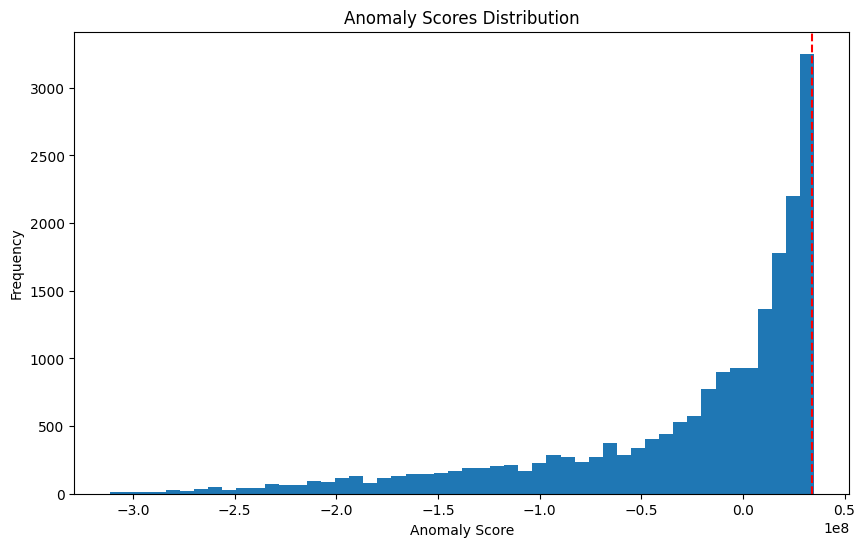

In [11]:
# For example, plot the anomaly scores


plt.figure(figsize=(10, 6))
plt.hist(best_anomaly_scores, bins=50)
plt.axvline(anomaly_threshold, color='red', linestyle='--')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
train_data_filtered_numeric = scaled_data_for_training.drop(columns=[time_column])

train_data_filtered_numeric

# fit the model with the best params
oc_svm_best = OneClassSVM(**best_params)
oc_svm_best.fit(train_data_filtered_numeric)

OneClassSVM(gamma='auto', kernel='poly')

In [13]:
# Ensure that only the common columns between training and testing data are used
common_columns = last_x_days_data.columns.intersection(train_data_filtered_numeric.columns)

# Reorder the columns in last_x_days_data to match the feature names used during training
last_x_days_data_reordered = last_x_days_data[common_columns]

In [14]:
# Perform prediction using the One-Class SVM model (temporary column)
last_x_days_data['raw_anomaly'] = oc_svm_best.predict(last_x_days_data_reordered)

# Convert the raw anomaly predictions (-1 for anomaly, 1 for normal) to (1 for anomaly, 0 for normal)
last_x_days_data['raw_anomaly'] = np.where(last_x_days_data['raw_anomaly'] == -1, 1, 0)

# Compute anomaly scores (negative of decision function)
ocsvm_anomaly_scores_new = -oc_svm_best.decision_function(last_x_days_data_reordered)

# Set a threshold at the 90th percentile
anomaly_threshold_new = np.percentile(ocsvm_anomaly_scores_new, anomaly_trashold)

# Identify anomalies based on the threshold
anomalies_new = ocsvm_anomaly_scores_new > anomaly_threshold_new

# Get the indices of the new anomalies in the reordered data
anomaly_indices_new = last_x_days_data_reordered.index[anomalies_new]  # Use index instead of iloc

# Update the 'anomaly' column in last_x_days_data based on the refined anomaly indices
last_x_days_data['anomaly'] = 0  # Reset all anomalies to 0
last_x_days_data.loc[anomaly_indices_new, 'anomaly'] = 1  # Set anomalies to 1 based on the original indices


In [15]:
## Identify and Analyse Anomlies

# Extract anomalies from the new data
anomalous_data_new = last_x_days_data_reordered.loc[anomaly_indices_new]

#print(f"Number of anomalies detected: {len(anomalous_data_new)}")


# Get descriptive statistics of the anomalies
anomalies_summary = anomalous_data_new.describe()
#print(anomalies_summary)

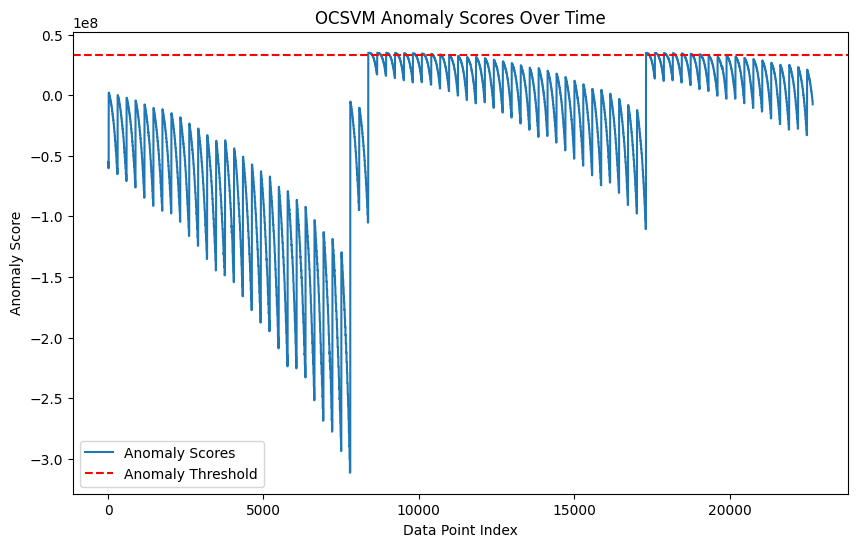

In [16]:
plot_anomaly_scores(
    anomaly_scores=ocsvm_anomaly_scores_new,
    anomaly_threshold=anomaly_threshold_new,
    title='OCSVM Anomaly Scores Over Time'
)


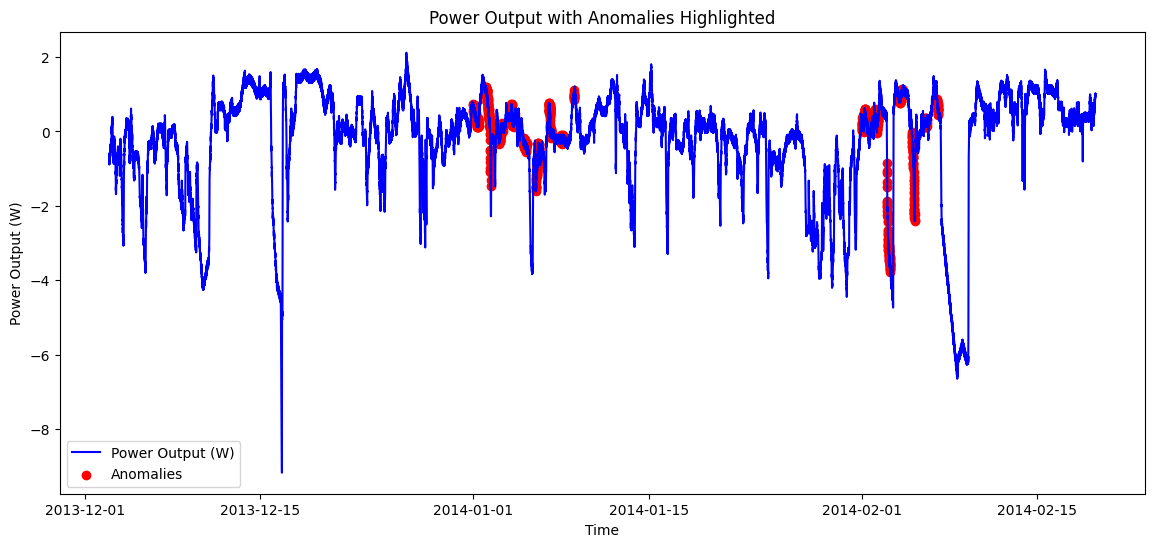

In [17]:
# Visualize anomalies in the power output
plot_anomalies(last_x_days_data, time_column=time_column, value_column=target_column, anomaly_column='anomaly')

In [18]:
# Saving the trained IsolationForest model using joblib

# Define the path for saving the model
model_save_path = f'USModels/ocsvm_model_{timesteps}.pkl'
scaler_save_path = f'USModels/scaler_ocsvm_{timesteps}.pkl'


# Save the model using joblib
joblib.dump(oc_svm_best, model_save_path)
# Save the scaler
joblib.dump(scaler, scaler_save_path)

model_save_path


'USModels/ocsvm_model_15.pkl'